In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

This is based on the [homework of week 5](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week05.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/tree/Experimental/data)
<br>
<br>
"These data are expert ratings of 20 different French and American wines by 9 different French and American judges. Your goal is to model score, the subjective rating assigned by each judge to each wine."

In [2]:
df = pd.read_csv('../data/Wines2012.csv', sep=';')
df.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


In [3]:
df.describe()

,score,wine.amer,judge.amer
count,180.000000,180.000000,180.000000
mean,14.200000,0.600000,0.555556
std,2.663953,0.491264,0.498290
min,7.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000
50%,14.500000,1.000000,1.000000
75%,16.000000,1.000000,1.000000
max,19.500000,1.000000,1.000000


Standardizing score:

In [4]:
df['score_std'] = (df['score'] - df['score'].mean()) / df['score'].std()
df.score_std

0     -1.576604
1     -0.450458
2     -0.075076
3      0.300306
4     -2.327368
         ...   
175   -0.825840
176    0.300306
177    0.675687
178   -2.702750
179    1.051069
Name: score_std, Length: 180, dtype: float64

## Modeling for judges and wines
Considering only variation among judges and wines by using index variables of them.

In [5]:
judge_cat = df['judge'].astype('category').cat.codes

# checking how it categorized the values
dict(enumerate(df.judge.astype('category').cat.categories))

{0: 'Daniele Meulder',
 1: 'Francis Schott',
 2: 'Jamal Rayyis',
 3: 'Jean-M Cardebat',
 4: 'John Foy',
 5: 'Linda Murphy',
 6: 'Olivier Gergaud',
 7: 'Robert Hodgson',
 8: 'Tyler Colman'}

In [6]:
wine_cat = df['wine'].astype('category').cat.codes

# checking how it categorized the values
dict(enumerate(df.wine.astype('category').cat.categories))

{0: 'A1',
 1: 'A2',
 2: 'B1',
 3: 'B2',
 4: 'C1',
 5: 'C2',
 6: 'D1',
 7: 'D2',
 8: 'E1',
 9: 'E2',
 10: 'F1',
 11: 'F2',
 12: 'G1',
 13: 'G2',
 14: 'H1',
 15: 'H2',
 16: 'I1',
 17: 'I2',
 18: 'J1',
 19: 'J2'}

As the outcome **score** was standardized the priors were chosen to be centered on 0 and having a standard deviation of 0.5.

In [7]:
SAMP_SIZE = 2000

with pm.Model() as m1:
    bJ = pm.Normal('bJ', 0, 0.5, shape=len(judge_cat.unique()))
    bW = pm.Normal('bW', 0, 0.5, shape=len(wine_cat.unique()))
    
    sigma = pm.Exponential('sigma', 1)
    mu = bJ[judge_cat] + bW[wine_cat]
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m1_trace = pm.sample(draws=SAMP_SIZE)
    
    # burned trace of the posterior
    m1_trace = m1_trace[int(SAMP_SIZE/4):]
    
    # posterior predictive
    m1_posterior_pred = pm.sample_posterior_predictive(m1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, bJ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'bJ\n0'}>,
        <AxesSubplot:title={'center':'bJ\n0'}>],
       [<AxesSubplot:title={'center':'bJ\n1'}>,
        <AxesSubplot:title={'center':'bJ\n1'}>],
       [<AxesSubplot:title={'center':'bJ\n2'}>,
        <AxesSubplot:title={'center':'bJ\n2'}>],
       [<AxesSubplot:title={'center':'bJ\n3'}>,
        <AxesSubplot:title={'center':'bJ\n3'}>],
       [<AxesSubplot:title={'center':'bJ\n4'}>,
        <AxesSubplot:title={'center':'bJ\n4'}>],
       [<AxesSubplot:title={'center':'bJ\n5'}>,
        <AxesSubplot:title={'center':'bJ\n5'}>],
       [<AxesSubplot:title={'center':'bJ\n6'}>,
        <AxesSubplot:title={'center':'bJ\n6'}>],
       [<AxesSubplot:title={'center':'bJ\n7'}>,
        <AxesSubplot:title={'center':'bJ\n7'}>],
       [<AxesSubplot:title={'center':'bJ\n8'}>,
        <AxesSubplot:title={'center':'bJ\n8'}>],
       [<AxesSubplot:title={'center':'bW\n0'}>,
        <AxesSubplot:title={'center':'bW\n0'}>],
       [<AxesSubplot:title={'c

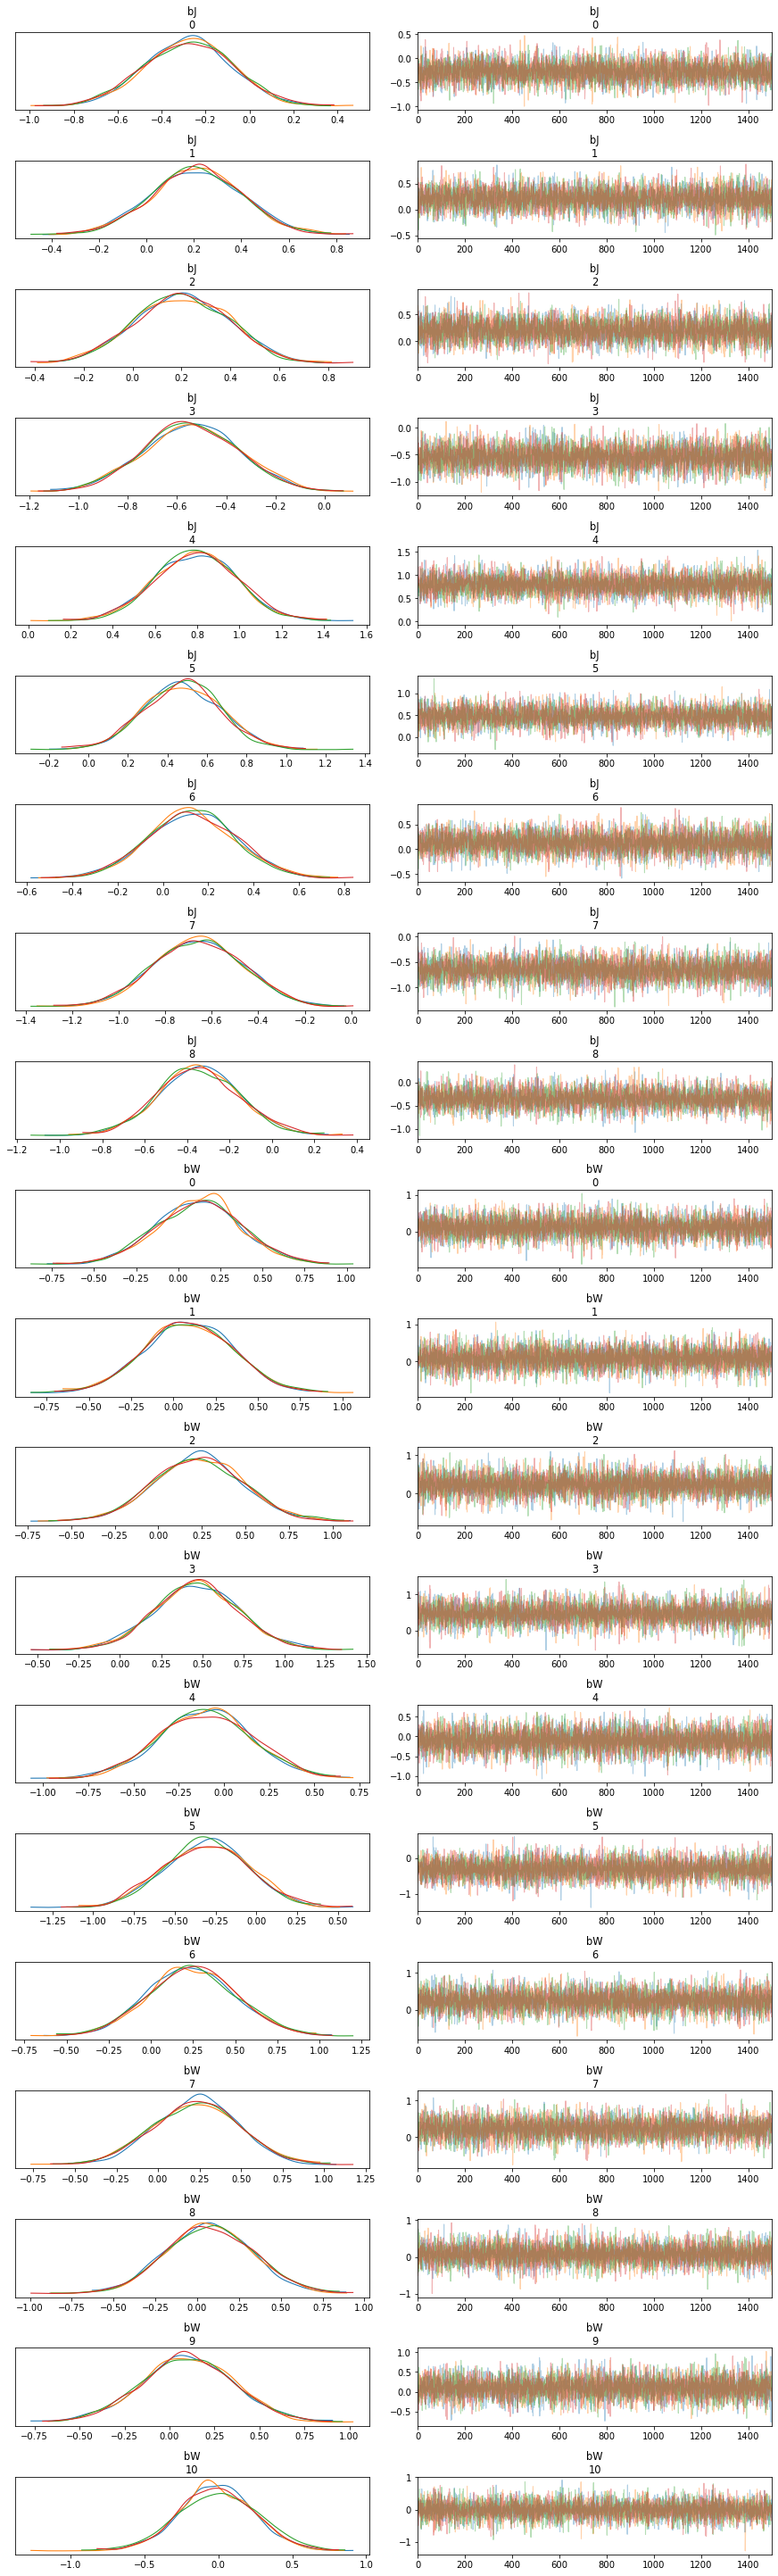

In [8]:
az.plot_trace(m1_trace)

All chains seem healthy as they all look like "hairy caterpillars". A more formal definition from the book follows: 
<br>
<br>
"*Now, how is this chain a healthy one? Typically we look for three things in these trace plots: (1) stationarity, (2) good mixing, and (3) convergence. Stationarity refers to the path of each chain staying within the same high-probability portion of the posterior distribution. Notice that these traces, for example, all stick around a very stable central tendency, the center of gravity of each dimension of the posterior. Another way to think of this is that the mean value of the chain is quite stable from beginning to end. Good mixing means that the chain rapidly explores the full region. It doesn’t slowly wander, but rather rapidly zig-zags around, as a good Hamiltonian chain should. Convergence means that multiple, independent chains stick around the same region of high probability.*"

In [9]:
az.summary(m1_trace, hdi_prob=.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bJ[0],-0.28,0.20,-0.59,0.04,0.0,0.0,7983.31,6647.10,7988.58,5510.82,1.0
bJ[1],0.21,0.19,-0.11,0.50,0.0,0.0,7380.01,5654.57,7378.39,4673.82,1.0
bJ[2],0.20,0.19,-0.09,0.53,0.0,0.0,7129.03,5721.09,7138.42,4328.14,1.0
bJ[3],-0.54,0.20,-0.86,-0.23,0.0,0.0,6896.10,6546.86,6903.99,4098.69,1.0
bJ[4],0.79,0.19,0.49,1.10,0.0,0.0,6879.67,6407.84,6879.95,4589.56,1.0
bJ[5],0.47,0.19,0.16,0.78,0.0,0.0,6945.70,6523.62,6938.51,4911.69,1.0
bJ[6],0.13,0.19,-0.19,0.43,0.0,0.0,7154.03,4827.77,7141.18,5042.53,1.0
bJ[7],-0.66,0.19,-0.96,-0.35,0.0,0.0,6807.03,6592.46,6813.95,4654.41,1.0
bJ[8],-0.35,0.19,-0.64,-0.03,0.0,0.0,6773.73,6198.81,6779.94,4848.64,1.0
bW[0],0.12,0.25,-0.29,0.52,0.0,0.0,9503.16,3897.36,9490.42,4771.11,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

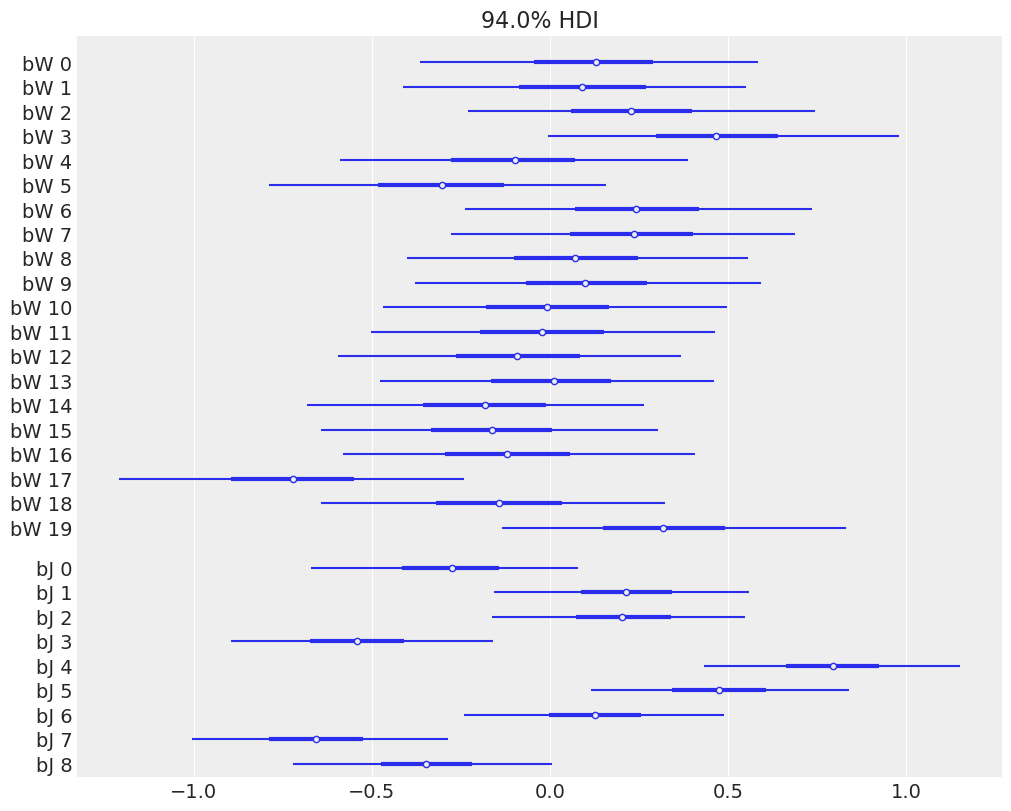

In [10]:
az.style.use("arviz-darkgrid")
az.plot_forest([m1_trace], 
              var_names=["bW", "bJ"],
              combined=True,
              figsize=[10,8])

The results show how much each judge and wine influence the scores. So for judges we can identify which ones give lowest and highest scores to wines. 
**Judge 4 (John Foy)** liked more the wines as, overall, he/she tends to give higher scores to them. On the other hand **judge 7 (Robert Hodgson)** liked the least the wines.
<br>
And for wines we can tell which ones are better evaluated by judges. In this dataset the wine judges liked the most is the one of **index 3 (B2)** and the wine that judges liked the least is clearly the wine **index 17 (I2)**.
<br>

---

## Modeling for flight, judge.amer, wine.amer
* flight: Whether the wine is red or white.
* wine.amer: Indicator variable for American (1) and French (0) wines.
* judge.amer: Indicator variable for American (1) and French (0) judges.

In [11]:
print('Flight unique values:', df['flight'].unique())
print('American judges unique values:', df['judge.amer'].unique())
print('American wines unique values:', df['wine.amer'].unique())

Flight unique values: ['white' 'red']
American judges unique values: [0 1]
American wines unique values: [1 0]


In [12]:
flight_cat = df['flight'].astype('category').cat.codes

# checking how it categorized the values
dict(enumerate(df.flight.astype('category').cat.categories))

{0: 'red', 1: 'white'}

In [13]:
SAMP_SIZE = 2000

with pm.Model() as m2:
    bF = pm.Normal('bF', 0, 0.5, shape=len(df['flight'].unique()))
    bW = pm.Normal('bW', 0, 0.5, shape=len(df['wine.amer'].unique()))
    bJ = pm.Normal('bJ', 0, 0.5, shape=len(df['judge.amer'].unique()))
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = bF[flight_cat] + bW[df['wine.amer']] + bJ[df['judge.amer']]
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m2_trace = pm.sample(draws=SAMP_SIZE)
    
    # burned trace of the posterior
    m2_trace = m2_trace[int(SAMP_SIZE/4):]
    # posterior predictive
    m2_posterior_pred = pm.sample_posterior_predictive(m2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bJ, bW, bF]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


array([[<AxesSubplot:title={'center':'bF\n0'}>,
        <AxesSubplot:title={'center':'bF\n0'}>],
       [<AxesSubplot:title={'center':'bF\n1'}>,
        <AxesSubplot:title={'center':'bF\n1'}>],
       [<AxesSubplot:title={'center':'bW\n0'}>,
        <AxesSubplot:title={'center':'bW\n0'}>],
       [<AxesSubplot:title={'center':'bW\n1'}>,
        <AxesSubplot:title={'center':'bW\n1'}>],
       [<AxesSubplot:title={'center':'bJ\n0'}>,
        <AxesSubplot:title={'center':'bJ\n0'}>],
       [<AxesSubplot:title={'center':'bJ\n1'}>,
        <AxesSubplot:title={'center':'bJ\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

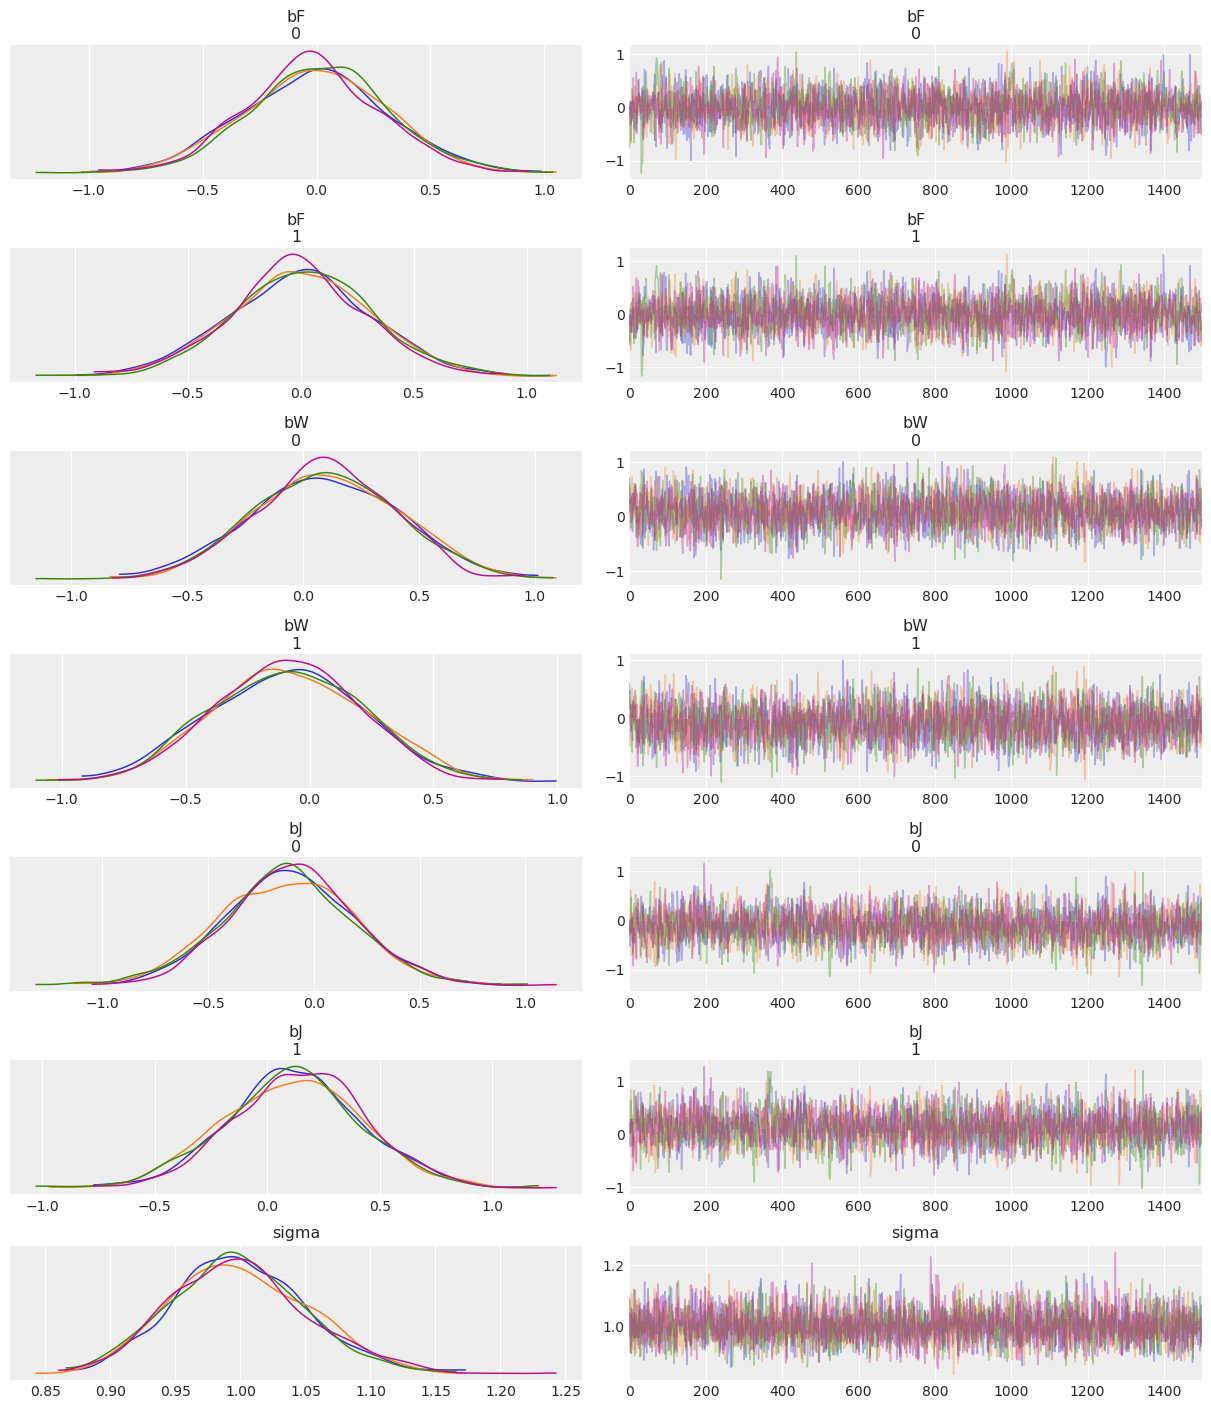

In [14]:
az.plot_trace(m2_trace)

All chains seem healthy as they all look like "hairy caterpillars".

In [15]:
az.summary(m2_trace, hdi_prob=.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bF[0],-0.00,0.31,-0.50,0.48,0.01,0.0,2902.55,2341.26,2909.68,3214.67,1.0
bF[1],-0.00,0.31,-0.50,0.49,0.01,0.0,2877.57,2365.98,2881.91,2850.62,1.0
bW[0],0.10,0.31,-0.41,0.58,0.01,0.0,2784.54,2604.21,2783.00,3049.96,1.0
bW[1],-0.09,0.31,-0.59,0.38,0.01,0.0,2720.83,2668.32,2717.36,3179.69,1.0
bJ[0],-0.12,0.31,-0.60,0.37,0.01,0.0,2726.58,2387.85,2728.87,3447.21,1.0
bJ[1],0.12,0.31,-0.37,0.60,0.01,0.0,2731.01,2338.10,2736.95,3136.90,1.0
sigma,1.00,0.05,0.91,1.08,0.00,0.0,4019.85,4009.01,4013.54,3823.45,1.0


There's no difference between red and white wines, as **bF[0]** and **bF[1]** have pretty much the same mean and standard deviation.<br>
American wines **bW[1]** receive slightly lower average scores than the French ones **bW[0]**.<br>
American judges **bJ[1]** slightly tend to give better scores to the wines than French judges **bJ[0]**. 

---

## Interactions
Interactions allow for the association between a predictor and an outcome to depend upon the value of another predictor.
<br>
<br>
The **two-way interactions** are between:
* Flight (red/white wine) and wine.amer (if the wine is American or French).
* Flight (red/white wine) and judge.amer (if the judge is American or French).
* wine.amer (if the wine is American or French) and judge.amer (if the judge is American or French).
<br> <br>
And the **three-way interaction** is:
* Flight (red/white wine), wine.amer (wine is American/French) and judge.amer (judge is American/French).

In [16]:
SAMP_SIZE = 2000

with pm.Model() as m3:
    bF = pm.Normal('bF', 0, 0.5, shape=len(df['flight'].unique()))
    bW = pm.Normal('bW', 0, 0.5, shape=len(df['wine.amer'].unique()))
    bJ = pm.Normal('bJ', 0, 0.5, shape=len(df['judge.amer'].unique()))
    bFW = pm.Normal('bFW', 0, 0.5, shape=len(df['judge.amer'].unique())*len(df['wine.amer'].unique()))
    bFJ = pm.Normal('bFJ', 0, 0.5, shape=len(df['judge.amer'].unique())*len(df['flight'].unique()))
    bWJ = pm.Normal('bWJ', 0, 0.5, shape=len(df['judge.amer'].unique())*len(df['wine.amer'].unique()))
    bFWJ = pm.Normal('bFWJ', 0, 0.5, shape=len(df['judge.amer'].unique())*len(df['wine.amer'].unique())*len(df['flight'].unique()))
    a = pm.Normal('a', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = a + bF[flight_cat] + bW[df['wine.amer']] + bJ[df['judge.amer']] + bFW[flight_cat*df['wine.amer']] + bFJ[flight_cat*df['judge.amer']] + bWJ[df['wine.amer']*df['judge.amer']] + bFWJ[flight_cat*df['wine.amer']*df['judge.amer']] 
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m3_trace = pm.sample(draws=SAMP_SIZE)
    
    # burned trace of the posterior
    m3_trace = m3_trace[int(SAMP_SIZE/4):]
    # posterior predictive
    m3_posterior_pred = pm.sample_posterior_predictive(m3_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bFWJ, bWJ, bFJ, bFW, bJ, bW, bF]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


In [17]:
m3_posterior_pred.keys()

dict_keys(['score_std'])

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'bF\n0'}>,
        <AxesSubplot:title={'center':'bF\n0'}>],
       [<AxesSubplot:title={'center':'bF\n1'}>,
        <AxesSubplot:title={'center':'bF\n1'}>],
       [<AxesSubplot:title={'center':'bW\n0'}>,
        <AxesSubplot:title={'center':'bW\n0'}>],
       [<AxesSubplot:title={'center':'bW\n1'}>,
        <AxesSubplot:title={'center':'bW\n1'}>],
       [<AxesSubplot:title={'center':'bJ\n0'}>,
        <AxesSubplot:title={'center':'bJ\n0'}>],
       [<AxesSubplot:title={'center':'bJ\n1'}>,
        <AxesSubplot:title={'center':'bJ\n1'}>],
       [<AxesSubplot:title={'center':'bFW\n0'}>,
        <AxesSubplot:title={'center':'bFW\n0'}>],
       [<AxesSubplot:title={'center':'bFW\n1'}>,
        <AxesSubplot:title={'center':'bFW\n1'}>],
       [<AxesSubplot:title={'center':'bFW\n2'}>,
        <AxesSubplot:title={'center':'bFW\n2'}>],
       [<AxesSubplot:title={'center':'bFW\n3'}>,
        <AxesSubplot:title={'center':'bFW\n3'}>],
       [<AxesSubplot:t

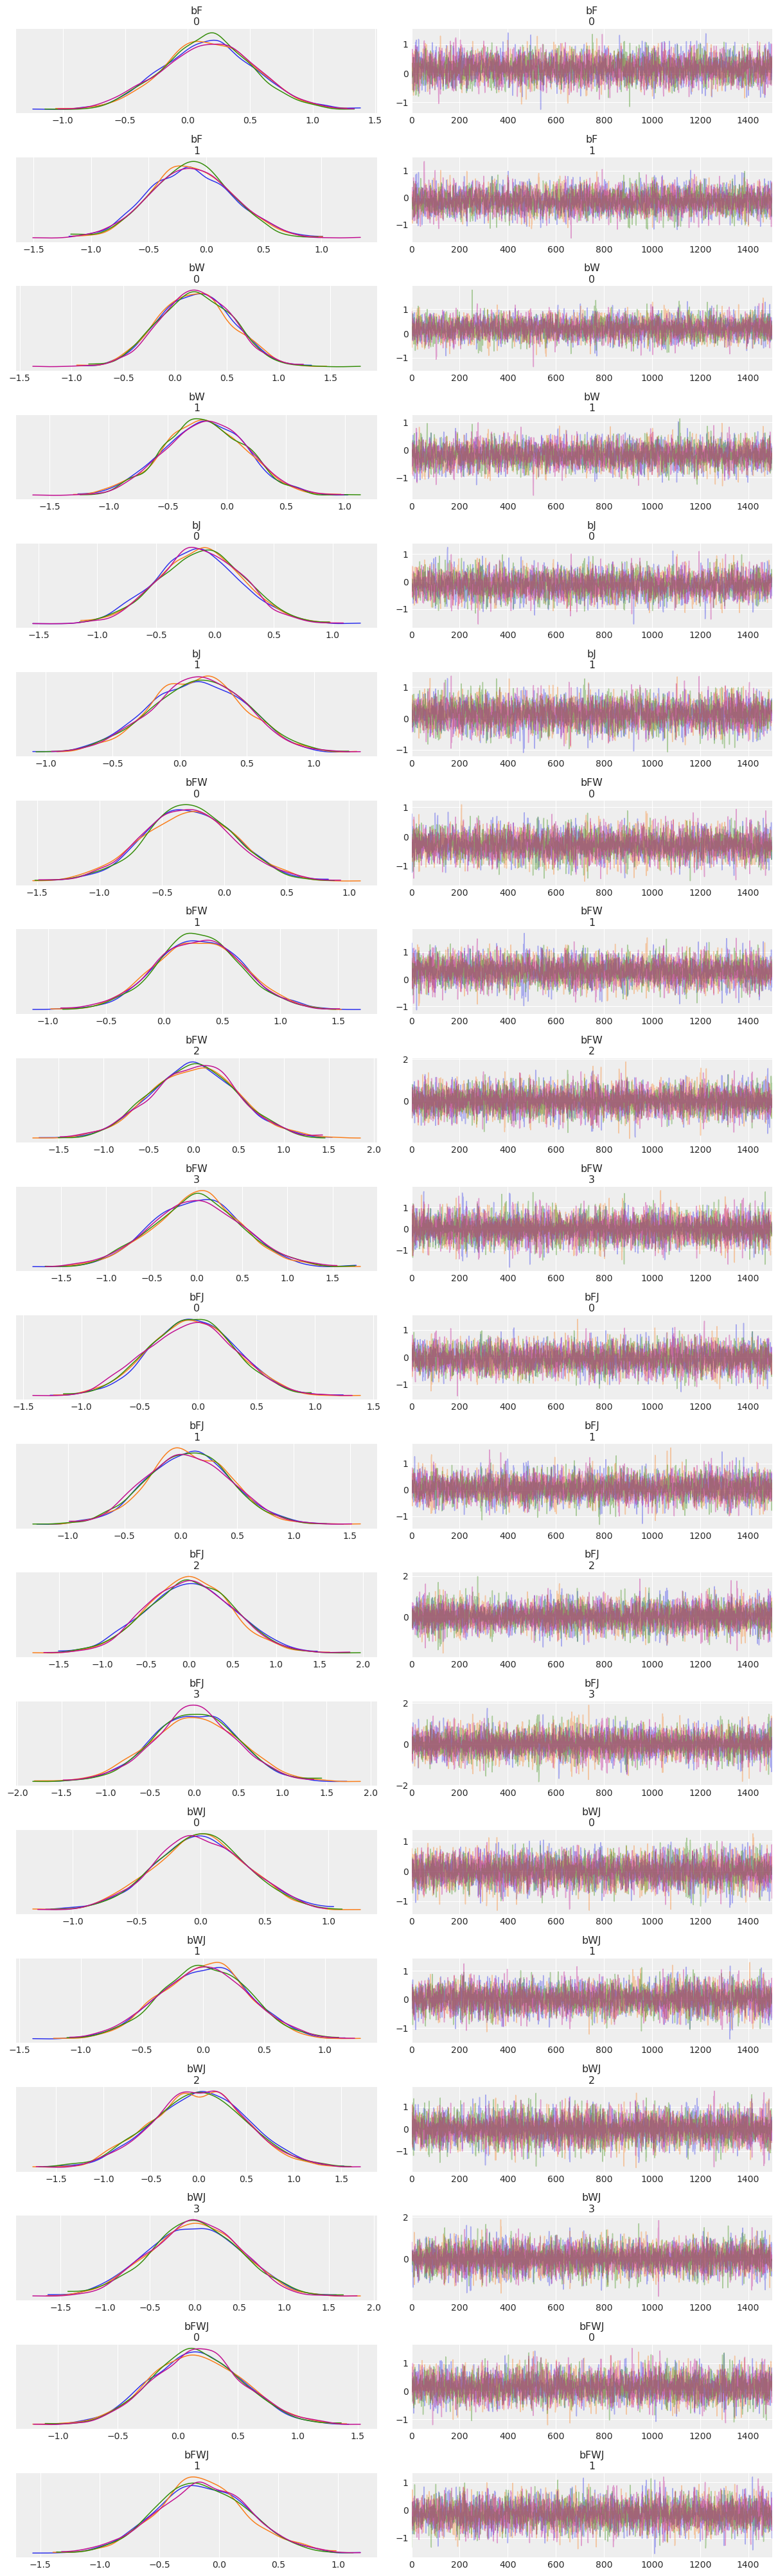

In [18]:
az.plot_trace(m3_trace)

All chains seem healthy as they all look like "hairy caterpillars".

In [19]:
az.summary(m3_trace, hdi_prob=.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bF[0],0.17,0.36,-0.43,0.73,0.00,0.00,5769.19,4027.63,5766.20,4685.90,1.0
bF[1],-0.13,0.36,-0.67,0.48,0.00,0.00,5659.45,4014.67,5687.59,4817.49,1.0
bW[0],0.20,0.35,-0.38,0.74,0.00,0.00,5274.74,4391.60,5271.25,4509.58,1.0
bW[1],-0.19,0.35,-0.78,0.34,0.00,0.00,5025.13,3892.05,5018.80,4682.05,1.0
bJ[0],-0.13,0.36,-0.71,0.45,0.00,0.00,5585.84,3435.26,5585.43,4366.03,1.0
bJ[1],0.13,0.35,-0.42,0.70,0.00,0.00,5468.89,3773.09,5467.43,4383.66,1.0
bFW[0],-0.28,0.37,-0.82,0.35,0.00,0.00,6502.37,4708.44,6501.40,4677.62,1.0
bFW[1],0.30,0.37,-0.34,0.86,0.00,0.00,7181.63,4715.14,7189.41,4477.93,1.0
bFW[2],0.00,0.49,-0.81,0.75,0.00,0.01,11592.06,2324.11,11583.30,4253.50,1.0
bFW[3],-0.00,0.50,-0.80,0.81,0.00,0.01,14392.02,2135.70,14415.69,3813.89,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

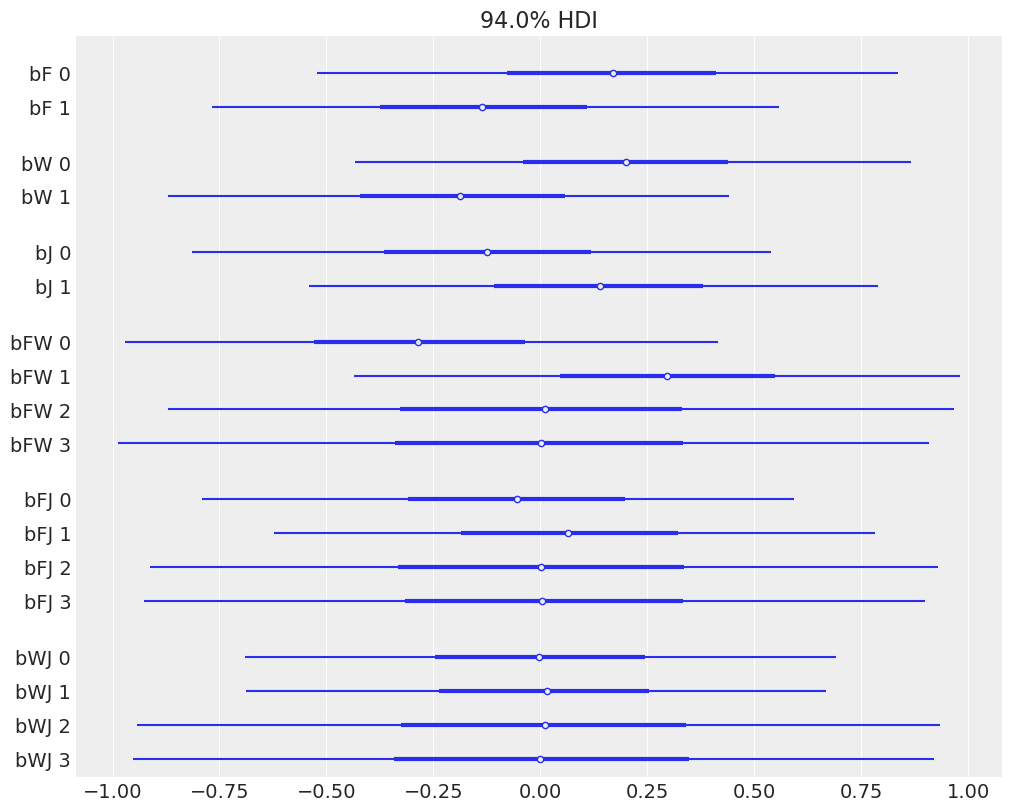

In [20]:
az.style.use("arviz-darkgrid")
az.plot_forest([m3_trace], 
              var_names=["bF", "bW", "bJ", "bFW", "bFJ", "bWJ"],
              combined=True,
              figsize=[10,8])

The interactions changed substantially most of the coefficients, which means they really played a role. 
<br>
<br>
Comparing to the model without interactions (**m2**):
* Now there's a clear distinction between the red (**bF[0]**) and white (**bF[1]**) wines. The red ones are more associated with higher scores than the white. 
<br>
* The American wines (**bW[0]**) receive even higher scores while the French wines (**bW[1]**) receive lower.  
* American judges (**bJ[0]**) still give higher scores than French judges (**bJ[1]**).
<br>
<br>
The interactions are really hard to interpret, what we can do is to observe them:
<br>
* Interactions between flights and judges (**bFJ**) are both 0. 
<br>
* Interactions between wines and judges (**bWJ**) have a small difference and are around 0. 
<br>
* On the other hand, interactions between flight and wine (**bFW**) are clearly distinguishable. 


Comparing the predictors of the 3 models:

In [21]:
df = df.assign(score_m1_pred=np.mean(m1_posterior_pred['score_std'],axis=0),
               score_m2_pred=np.mean(m2_posterior_pred['score_std'],axis=0),
               score_m3_pred=np.mean(m3_posterior_pred['score_std'],axis=0))
df.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std,score_m1_pred,score_m2_pred,score_m3_pred
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.576604,-0.409761,-0.204971,-0.031276
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.450458,-0.298822,-0.202016,-0.027027
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075076,-0.656883,-0.015947,-0.235137
3,Jean-M Cardebat,white,D1,15.0,0,0,0.300306,-0.314241,-0.004925,-0.215493
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.327368,-0.480537,-0.196092,-0.033396


In [22]:
# group by wine, judge and flight and populate a new dataframe with the mean of the scores and the predictors
class_grp = df.groupby(['wine.amer', 'judge.amer','flight'])['score_std','score_m1_pred', 'score_m2_pred','score_m3_pred'].mean().reset_index()
categories = ['FFR', 'FFW', 'FAR', 'FAW', 'AFR', 'AFW', 'AAR', 'AAW'] # wine, judge and flight order
class_grp['categories'] = categories

In [23]:
class_grp

,wine.amer,judge.amer,flight,score_std,score_m1_pred,score_m2_pred,score_m3_pred,categories
0,0,0,red,0.253383,0.097541,-0.018065,0.070208,FFR
1,0,0,white,-0.380074,-0.169813,-0.016745,-0.215038,FFW
2,0,1,red,0.319075,0.315337,0.214721,0.331791,FAR
3,0,1,white,0.197076,0.048320,0.217999,0.155738,FAW
4,1,0,red,-0.419176,-0.269709,-0.207575,-0.311177,AFR
5,1,0,white,0.042230,-0.087222,-0.205803,-0.024364,AFW
6,1,1,red,-0.018769,-0.049950,0.033047,-0.040355,AAR
7,1,1,white,0.043795,0.131828,0.032237,0.061922,AAW


[]

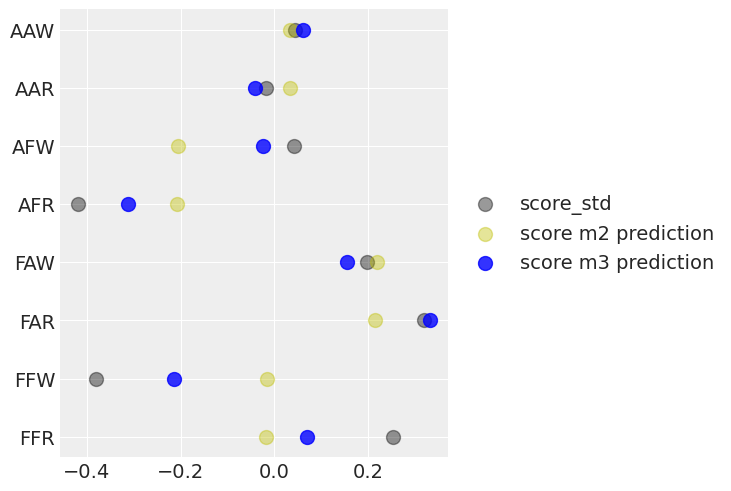

In [24]:
y_axis = np.linspace(0,7,8)

fig, ax = plt.subplots() 
ax.scatter(class_grp.score_std, y_axis, c="k", s=100, alpha=0.4, label="score_std")
ax.scatter(class_grp.score_m2_pred, y_axis, c="y", s=100, alpha=0.4, label="score m2 prediction")
ax.scatter(class_grp.score_m3_pred, y_axis, c="b", s=100, alpha=0.8, label="score m3 prediction")

ax.set_yticks(y_axis) 
ax.set_yticklabels(('FFR', 'FFW', 'FAR', 'FAW', 'AFR', 'AFW', 'AAR', 'AAW'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

For the graph above the labels follow the order **[wine, judge, flight]**.
<br>
Therefore AAW stands for [American wine, American judge, white wine] and FFR for [French wine, French judge, red wine].
<br>
<br>
We can notice that we've got better predictors on average using the model m3 (the model with interactions) for all categories, except for AAW and FAW even though not with a big difference.

---
---

In [25]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Wed Jan 27 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3     : 3.9.3
pandas    : 1.1.3
numpy     : 1.19.2
arviz     : 0.10.0
scipy     : 1.5.2
matplotlib: 3.3.2
seaborn   : 0.11.0

Watermark: 2.1.0

